In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from skimage.color import rgb2lab
import sys
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [2]:
OUTPUT_TEMPLATE = (
    'Bayesian classifier:    {bayes_rgb:.3f} {bayes_convert:.3f}\n'
    'kNN classifier:         {knn_rgb:.3f} {knn_convert:.3f}\n'
    'Rand forest classifier: {rf_rgb:.3f} {rf_convert:.3f}\n'
)

In [3]:
# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 113, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 186, 186),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])

In [4]:
def plot_predictions(model, lum=70, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)


In [5]:
def RGB_to_LAB(X):
    rgb2lab(X)
    return X

Bayesian classifier:    0.561 0.561
kNN classifier:         0.740 0.740
Rand forest classifier: 0.728 0.732



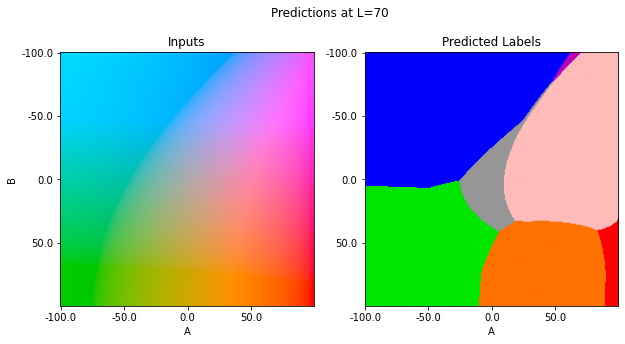

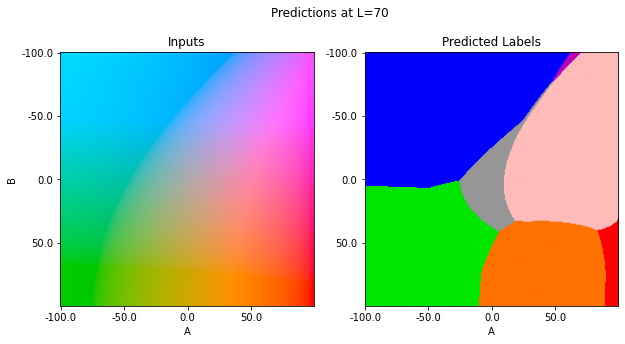

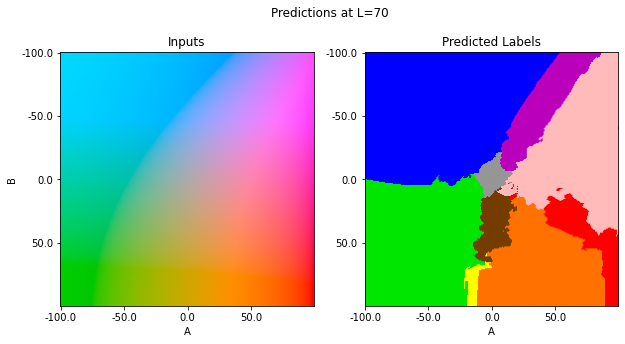

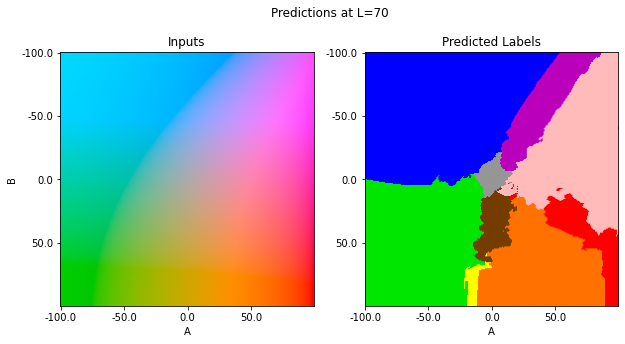

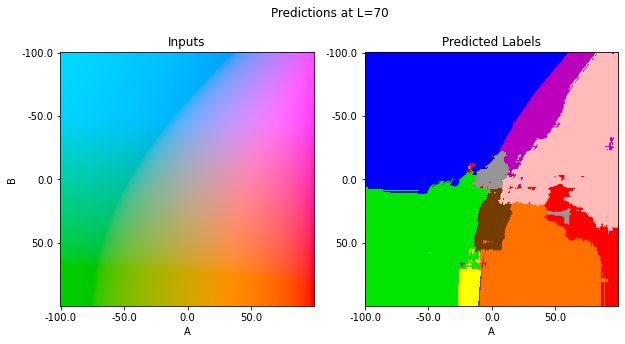

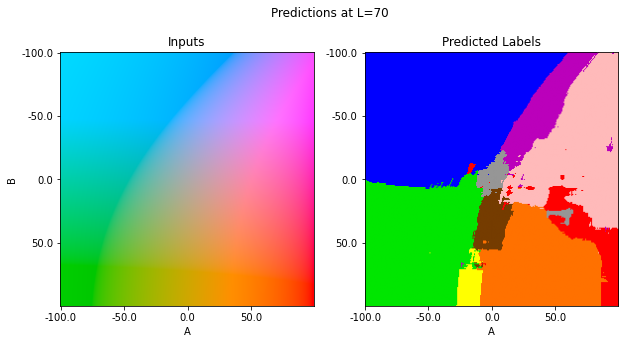

In [6]:
def main():
    #data = pd.read_csv(sys.argv[1])
    data = pd.read_csv("colour-data.csv")
    X = data[['R', 'G', 'B']].values / 255
    y = data['Label'].values

    # TODO: create some models
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    #GaussianNB
    bayes_rgb_model=GaussianNB()
    bayes_convert_model = make_pipeline(
        FunctionTransformer(RGB_to_LAB),
        GaussianNB()
    )
    
    #Knn
    from sklearn.neighbors import KNeighborsClassifier
    knn_rgb_model=KNeighborsClassifier(n_neighbors=9)
    knn_convert_model = make_pipeline(
        FunctionTransformer(RGB_to_LAB),
        KNeighborsClassifier(n_neighbors=9)
    )
    
    #Random Forest
    from sklearn.ensemble import RandomForestClassifier
    rf_rgb_model = RandomForestClassifier(n_estimators=150)
    rf_convert_model = make_pipeline(
        FunctionTransformer(RGB_to_LAB),
        RandomForestClassifier(n_estimators=150)
    )


    # train each model and output image of predictions
    models = [bayes_rgb_model, bayes_convert_model, knn_rgb_model, knn_convert_model, rf_rgb_model, rf_convert_model]
    for i, m in enumerate(models):  # yes, you can leave this loop in if you want.
        m.fit(X_train, y_train)
        plot_predictions(m)
        plt.savefig('predictions-%i.png' % (i,))

    print(OUTPUT_TEMPLATE.format(
        bayes_rgb=bayes_rgb_model.score(X_valid, y_valid),
        bayes_convert=bayes_convert_model.score(X_valid, y_valid),
        knn_rgb=knn_rgb_model.score(X_valid, y_valid),
        knn_convert=knn_convert_model.score(X_valid, y_valid),
        rf_rgb=rf_rgb_model.score(X_valid, y_valid),
        rf_convert=rf_convert_model.score(X_valid, y_valid),
    ))


if __name__ == '__main__':
    main()